## Scores of baseline model and seven regression models - <br /> by Jerome Sauer, 17 December 2021 ##

---

In [26]:
## load modules
import os
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from modeling.functions import baseline, modelling_fc, get_features

from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor 

from sklearn.preprocessing import MinMaxScaler

RSEED = 42


## Preparation of data for modelling ##
Read data, linearly interpolate missing values and create dummies for cardinal wind directions.

In [27]:
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data_incl_features.csv', parse_dates=['TIMESTAMP'], index_col='TIMESTAMP')
data.interpolate(method='linear', inplace=True)
data = pd.get_dummies(data, columns = ['WD100CARD','WD10CARD'], drop_first=True)
data.head()

,ZONEID,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,IS_HOLIDAY,...,WD10CARD_NNW,WD10CARD_NW,WD10CARD_S,WD10CARD_SE,WD10CARD_SSE,WD10CARD_SSW,WD10CARD_SW,WD10CARD_W,WD10CARD_WNW,WD10CARD_WSW
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,1,0.000000,2.124600,-2.681966,2.864280,-3.666076,1,1,6,1,...,0,1,0,0,0,0,0,0,0,0
2012-01-01 02:00:00,1,0.054879,2.521695,-1.796960,3.344859,-2.464761,2,1,6,1,...,0,1,0,0,0,0,0,0,0,0
2012-01-01 03:00:00,1,0.110234,2.672210,-0.822516,3.508448,-1.214093,3,1,6,1,...,0,0,0,0,0,0,0,0,1,0
2012-01-01 04:00:00,1,0.165116,2.457504,-0.143642,3.215233,-0.355546,4,1,6,1,...,0,0,0,0,0,0,0,1,0,0
2012-01-01 05:00:00,1,0.156940,2.245898,0.389576,2.957678,0.332701,5,1,6,1,...,0,0,0,0,0,0,0,1,0,0


Use the first 75 % of the data as training/validation set and the last 25 % as a test set. In addition, get a dictionary with different feature combinations.

In [28]:
data_train = data[:'2013-07-01 00:00:00']
data_test = data['2013-07-01 01:00:00':]
feature_dict = get_features(data)

## Run models ##
Run models by calling the function "modelling_fc" and save scores and model parameter in "../results/{MODEL}.csv".

In [29]:
## Define a list with models to be run. Pass 'Baseline' for the baseline model, otherwise the model object. 
models = ['Baseline']

for model in models:

    # Baseline
    if model == 'Baseline':
        results = baseline(data_train, data_test)

    # RandomForest
    if model.__class__.__name__ == 'RandomForestRegressor':
        param_grid = {'n_estimators' : [100,150], 'max_depth' : np.arange(15,31,5), 'min_samples_leaf' : np.arange(10,21,10)}
        results = modelling_fc(data_train, data_test, feature_dict, model, param_grid = param_grid, scaler=MinMaxScaler(), n_jobs=3)

    # Linear regression
    if model.__class__.__name__ == 'LinearRegression':
        param_grid = {'fit_intercept' : [True]}
        results = modelling_fc(data_train, data_test, feature_dict, model, param_grid = param_grid, scaler=MinMaxScaler(), n_jobs=-1)

    # XGBoost
    if model.__class__.__name__ == 'XGBRegressor':
        param_grid = {'random_state' : [RSEED]}
        results = modelling_fc(data_train, data_test, feature_dict, model, param_grid = param_grid, scaler = MinMaxScaler(), n_jobs=-1)

    # LGBM
    if model.__class__.__name__ == 'LGBMRegressor':
        param_grid = [{'n_estimators' : [100]},
                      {'n_estimators' : [1000], 'num_leaves' : [20]},
                      {'n_estimators' : [50], 'num_leaves': [62]}]
        results = modelling_fc(data_train, data_test, feature_dict, model, param_grid = param_grid, scaler = MinMaxScaler(), n_jobs=-1)

    # KNN
    if model.__class__.__name__ == 'KNeighborsRegressor': 
        param_grid = {'n_neighbors' : np.arange(20,141,10), 'weights' : ['uniform','distance'], 'p' : [1,2]}
        results = modelling_fc(data_train, data_test, feature_dict, model, scaler = MinMaxScaler(), param_grid = param_grid)

    # remove file before new file is created
    if os.path.isfile(f'../results/{results.MODEL.iloc[1]}.csv'):
        os.remove(f'../results/{results.MODEL.iloc[1]}.csv')

    # save results in csv file
    results.to_csv(f'../results/{results.MODEL.iloc[1]}.csv')

## Results ##
Plot validation-RMSE by model for predictions aggregated over all wind farms. 

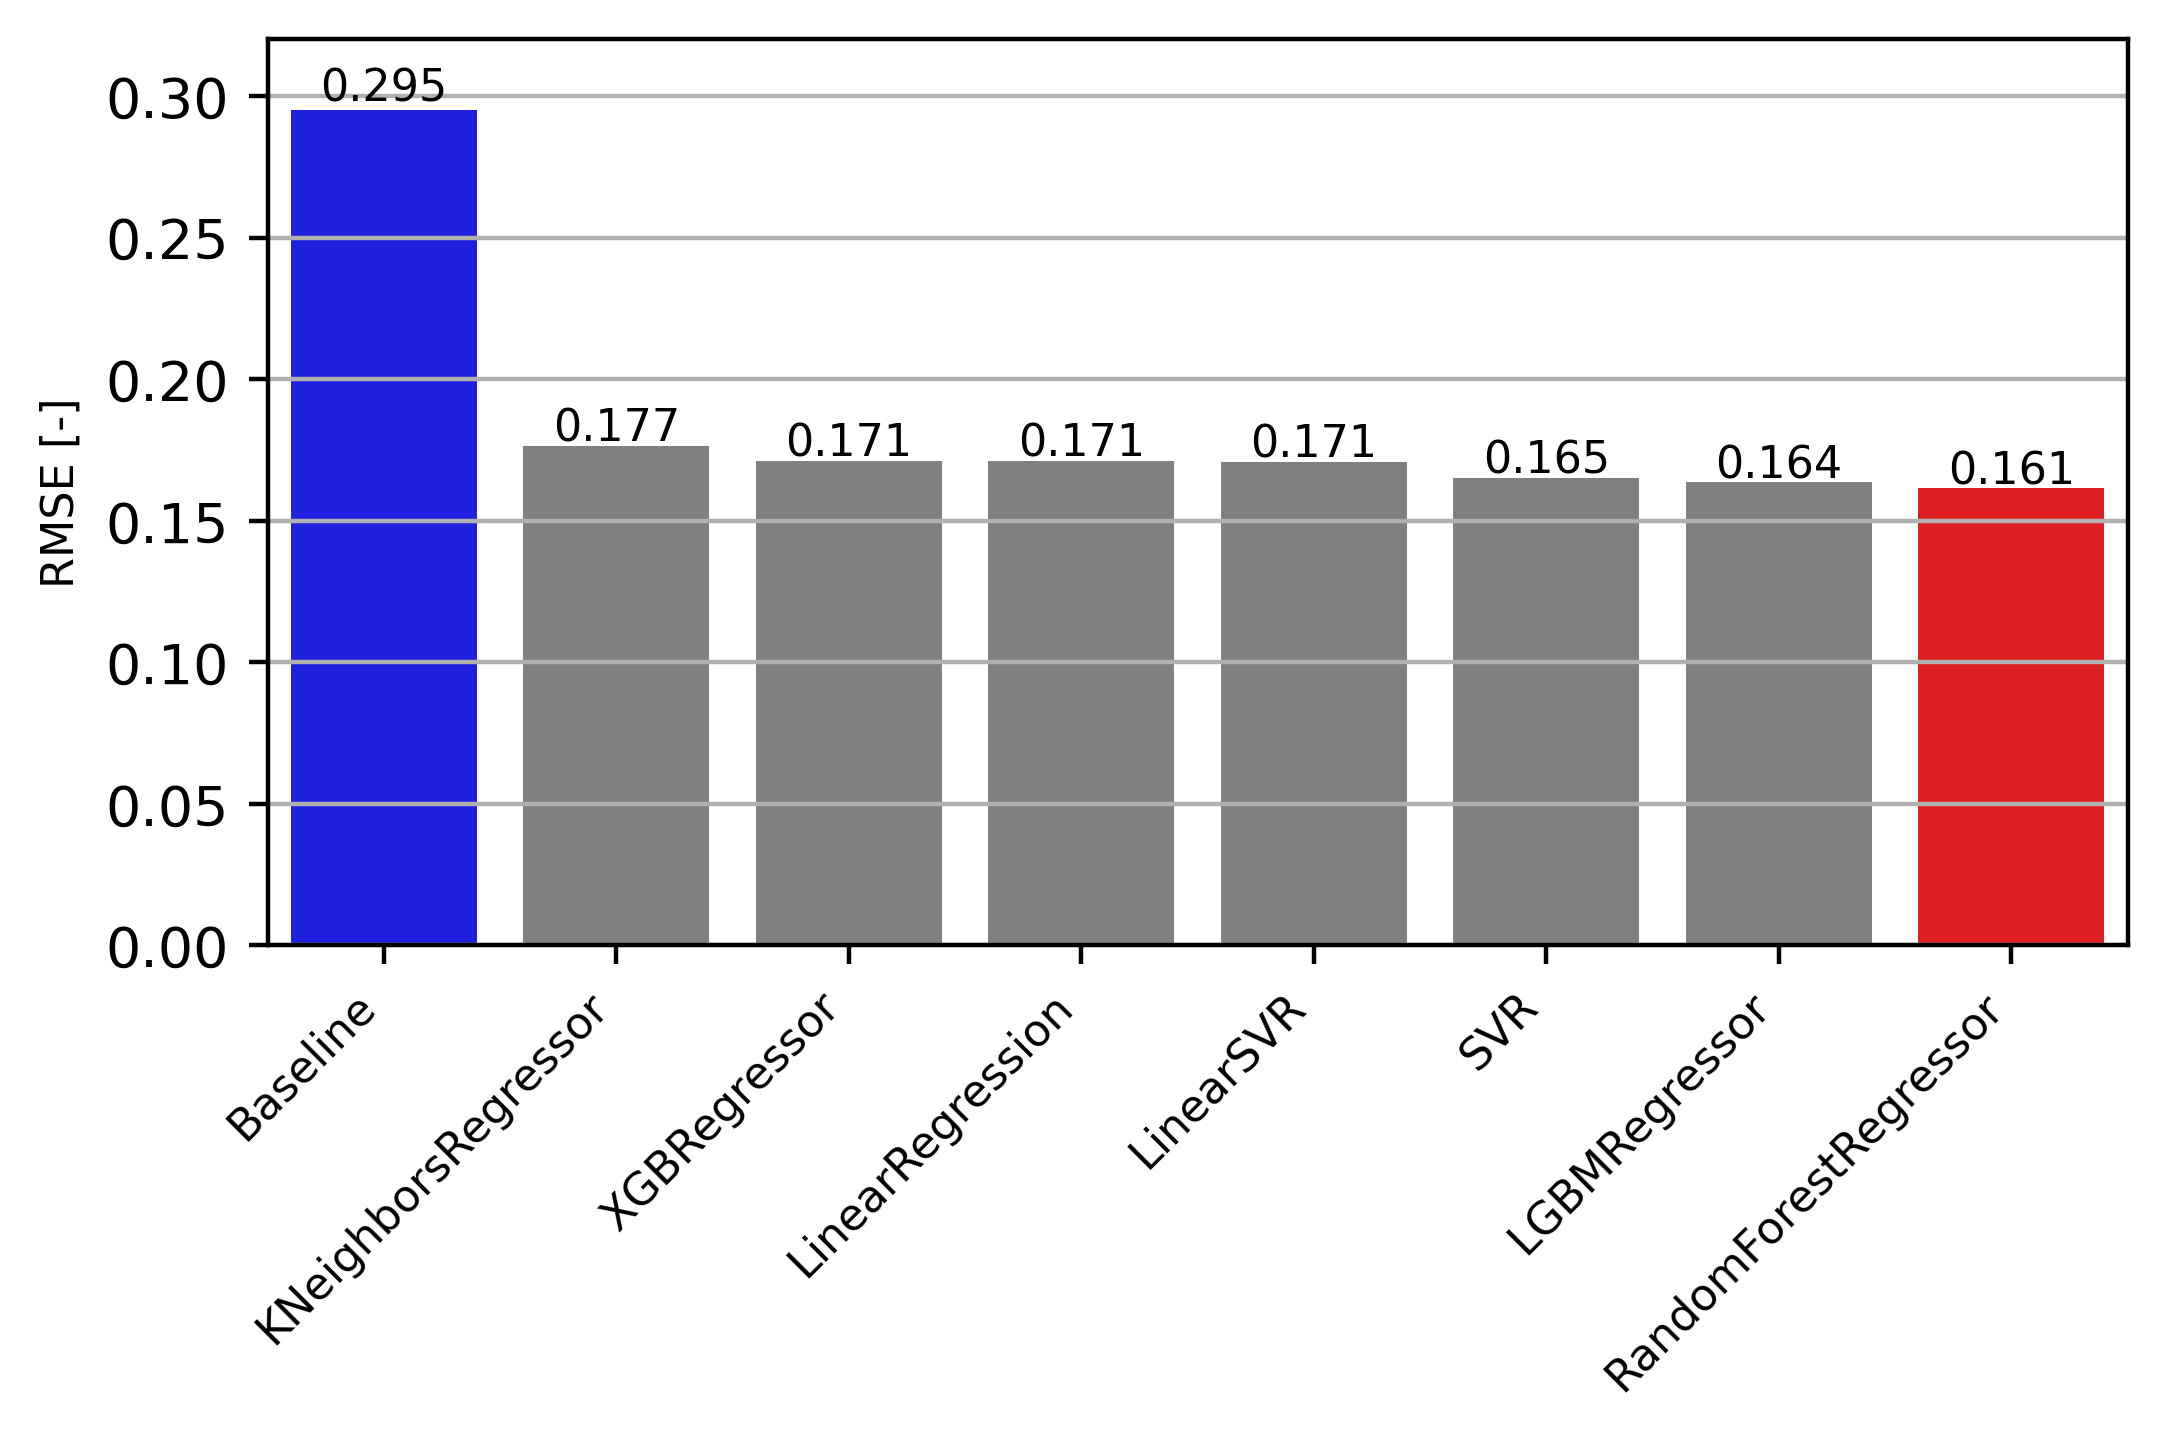

In [30]:
## define models to plot
models = ['Baseline','LinearRegression', 'KNeighborsRegressor', 'RandomForestRegressor','LinearSVR', 'SVR', 'LGBMRegressor', 'XGBRegressor']

## collect scores in the dataframe "scores"
scores= pd.DataFrame(index = models, columns = ['TESTSCORE','VALSCORE'])

for model in models:

    df = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')

    if model == 'Baseline':
        scores.loc[model]['VALSCORE'] = df.loc['TOTAL'].TRAINSCORE
        scores.loc[model]['TESTSCORE'] = df.loc['TOTAL'].TESTSCORE
    else:
        scores.loc[model]['VALSCORE'] = np.sqrt(np.mean(df.CV**2))
        scores.loc[model]['TESTSCORE'] = np.sqrt(np.mean(df.TESTSCORE**2))

scores = scores.sort_values(by='VALSCORE', ascending=False)
scores.index.set_names('MODEL', inplace=True)
scores.reset_index(inplace=True)

## plot
fontsize=8
palette = ['blue'] + 6 * ['gray'] + ['red']

fig, ax = plt.subplots(dpi=400, figsize=(6,3))
bp = sns.barplot(data = total, x = 'MODEL', y = 'VALSCORE', ax=ax, dodge=False, palette = palette)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right', fontsize=fontsize)
ax.set(xlabel=None)
ax.set_ylabel('RMSE [-]', fontsize=fontsize)
ax.set_ylim([.0,.32]);
ax.yaxis.grid()

for index, row in scores.iterrows():
    bp.text(row.name, row.VALSCORE + row.VALSCORE/100, '{:.3f}'.format(row.VALSCORE), ha='center', fontsize=fontsize)


Plot validation-RMSE by wind farm for different models.

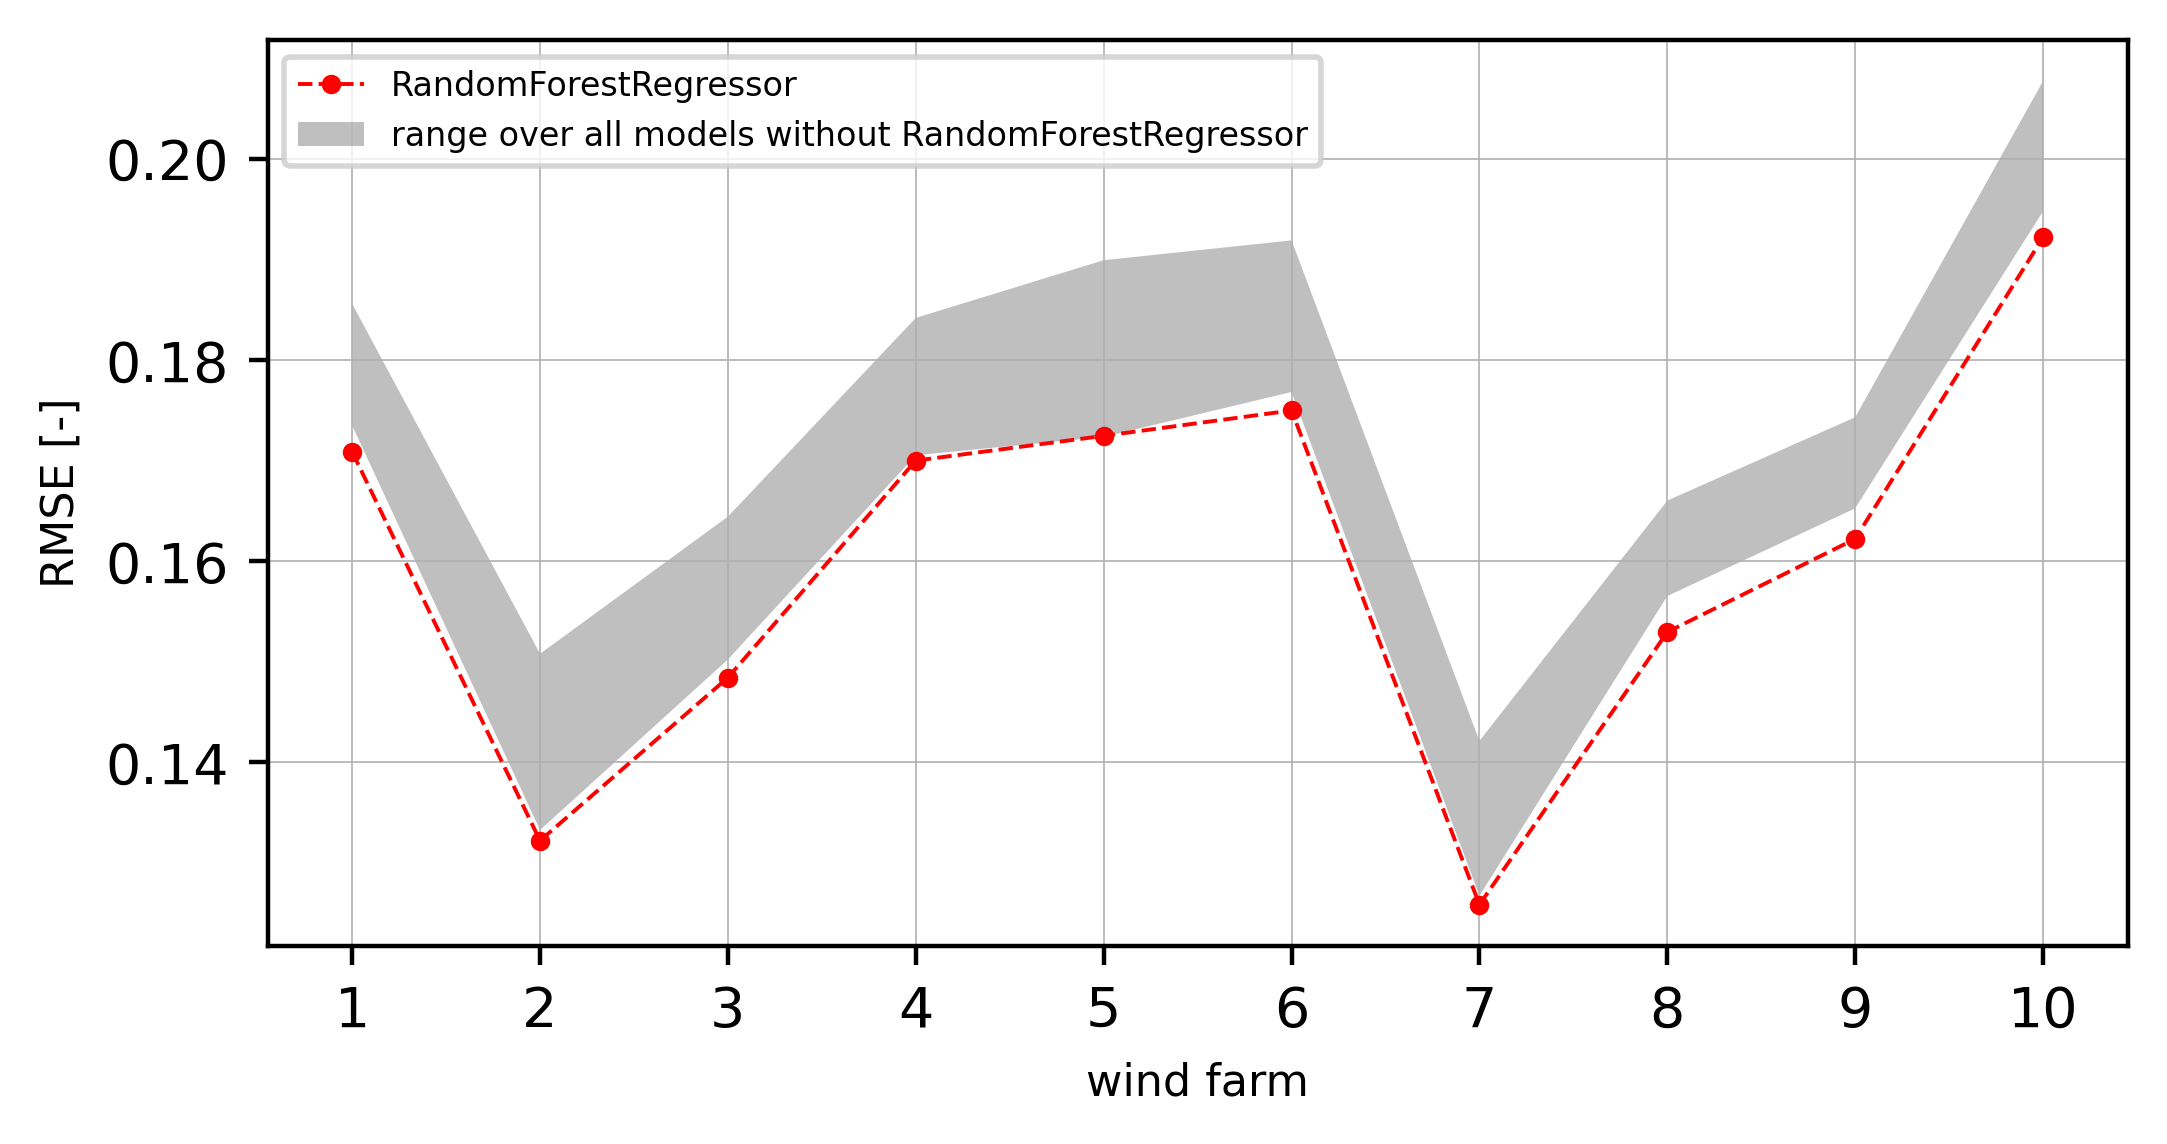

In [31]:
## Plot RMSE by wind farm for different models
scores = pd.DataFrame(columns = ['ZONE','MODEL','VALSCORE'])
scores.set_index('ZONE', inplace=True)

## select models
models = ['Baseline','LinearRegression', 'KNeighborsRegressor', 'RandomForestRegressor','LinearSVR', 'SVR', 'LGBMRegressor', 'XGBRegressor']

for model in models:
    df = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')
    df = df[['CV','MODEL']]
    df.rename(columns={'CV':'VALSCORE'}, inplace=True)
    scores = scores.append(df) 

scores = scores.loc[scores.index != 'TOTAL']
ranges = scores[scores.MODEL != 'RandomForestRegressor']
scores = scores[scores.MODEL == 'RandomForestRegressor'][['VALSCORE']]
scores['MINVAL'] = [ranges.loc[zone]['VALSCORE'].min() for zone in ranges.index.unique()]
scores['MAXVAL'] = [ranges.loc[zone]['VALSCORE'].max() for zone in ranges.index.unique()]

## plot
fig, ax = plt.subplots(dpi=400, figsize=(6,3))
ax.plot(scores.index.unique(), scores['VALSCORE'], color='r', linestyle='--', marker='.', markersize=5, linewidth=.7)
ax.fill_between(scores.index.unique(), scores['MINVAL'], scores['MAXVAL'], color = 'gray', alpha=.5, edgecolor=None);
ax.set_xlabel('wind farm',fontsize=fontsize)
ax.set_ylabel('RMSE [-]', fontsize=fontsize)
ax.grid(linewidth=.3)
ax.legend(['RandomForestRegressor','range over all models without RandomForestRegressor'], fontsize=fontsize - 2, loc = 'upper left')
ax.set_xticklabels([zone[-1] if len(zone) == 5 else zone[-2:] for zone in scores.index]);
ax.set_xticklabels(range(1,11));